### FEMNIST data loading demo

The demo is showing how to load pre-partitioned (by writer) FEMNIST data using Pytorch (torch.utils.data.Dataset) and the pre-partitioned data in .json from this [repo](https://github.com/wingter562/LEAF_prepartitioned/tree/main/femnist_sf02), which was obtained by running the [LEAF script](https://github.com/TalwalkarLab/leaf/tree/master/data/femnist) for FEMNIST.

In [1]:
# check the directory tree and create a dir for the CIFAR dataset
!ls -lh
!mkdir datasets

total 4.0K
drwxr-xr-x 1 root root 4.0K Oct  8 13:45 sample_data


In [2]:
# import packages
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

In [3]:
# download pre-partitioned data, which is a zip of two dirs (train and test) each of which
# contains multiple files of .json data
%cd /content/datasets/
!git clone https://github.com/wingter562/LEAF_prepartitioned.git
# unzip
%cd LEAF_prepartitioned/femnist_sf02/
!unzip -q femnist_sf02.zip
!ls -lh

/content/datasets
Cloning into 'LEAF_prepartitioned'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 69 (delta 0), reused 4 (delta 0), pack-reused 56
Unpacking objects: 100% (69/69), done.
/content/datasets/LEAF_prepartitioned/femnist_sf02
total 39M
-rw-r--r-- 1 root root  39M Oct 21 19:36 femnist_sf02.zip
drwxr-xr-x 2 root root 4.0K Oct 20 16:26 test
drwxr-xr-x 2 root root 4.0K Oct 20 16:26 train


Now we use python's json library to parse the .json files into in-memory data structures. See this [repo](https://github.com/wingter562/LEAF_prepartitioned/tree/main/femnist_sf02) for the details on how the user-image data are organized in the .json files. Part of the following source code is extracted from the [LEAF repo](https://github.com/TalwalkarLab/leaf/tree/master/data/femnist).

In [5]:
# A function for parsing all json files in a specified directory
# Note that both train/ and test/ dirs may have multiple files to load
from collections import defaultdict
import os
import json

def read_dir(data_dir):
  clients = []
  datasize = 0
  groups = []
  data = defaultdict(lambda : None)

  files = os.listdir(data_dir)
  files = [f for f in files if f.endswith('.json')]
  for f in files:
    file_path = os.path.join(data_dir,f)
    print('loading %s...' % file_path)
    with open(file_path, 'r') as inf:
      cdata = json.load(inf)
    #clients.extend(cdata['users'])
    datasize += sum(cdata['num_samples'])
    if 'hierarchies' in cdata:
      groups.extend(cdata['hierarchies'])
    data.update(cdata['user_data'])

  clients = list(sorted(data.keys()))
  return clients, groups, data, datasize

Now we use the function to load train and test data separately

In [6]:
# load train and test data separately
clients, groups, data_train, size_train = read_dir('train')
_, _, data_test, size_test = read_dir('test')
# show metadata
print('clients:', clients)
print('number of clients:', len(clients))
print('training data size:', size_train)
print('test data size:', size_test)
# show data shape
print('user data shape x:', np.array(data_train[clients[0]]['x']).shape)
print('user data shape y:', np.array(data_train[clients[0]]['y']).shape)

loading train/all_data_1_niid_2_train_9.json...
loading train/all_data_32_niid_2_train_9.json...
loading train/all_data_3_niid_2_train_9.json...
loading train/all_data_9_niid_2_train_9.json...
loading train/all_data_17_niid_2_train_9.json...
loading train/all_data_34_niid_2_train_9.json...
loading train/all_data_24_niid_2_train_9.json...
loading train/all_data_21_niid_2_train_9.json...
loading train/all_data_22_niid_2_train_9.json...
loading train/all_data_19_niid_2_train_9.json...
loading train/all_data_23_niid_2_train_9.json...
loading train/all_data_12_niid_2_train_9.json...
loading train/all_data_31_niid_2_train_9.json...
loading train/all_data_29_niid_2_train_9.json...
loading train/all_data_33_niid_2_train_9.json...
loading train/all_data_6_niid_2_train_9.json...
loading train/all_data_10_niid_2_train_9.json...
loading train/all_data_13_niid_2_train_9.json...
loading train/all_data_25_niid_2_train_9.json...
loading train/all_data_27_niid_2_train_9.json...
loading train/all_data_1

As we can see, the function above loads all the json files within a specifed directory into a list of user_ids, a list of (potential) groups, and a dictionary of user data. The user data is provided in the following format of hierarchical dictionary:
- user_id: data
  - 'x': input features as a nested list, shape=(data_size, $28^2$)
  - 'y': labels as a plain list, length=data_size

Now we wrap the data into custom Pytorch dataset objects:

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

# define a custom dataset class
class FEMNIST_client_dataset(Dataset):
  def __init__(self, user_id, user_data, transform=None, target_transform=None):
    self.user_id = user_id
    self.data_dict = user_data
    self.transform = transform
    self.target_transform = target_transform
    # size
    assert len(self.data_dict['x']) == len(self.data_dict['y'])
    self.data_size = len(self.data_dict['x'])
    # extract the features and labels from the data {'x':images, 'y':labels}
    self.images = np.array(self.data_dict['x']).reshape(self.data_size, 28, 28)
    self.labels = np.array(self.data_dict['y'])
  
  def get_userid(self):
    return self.user_id

  def __len__(self):
    return self.data_size

  def __getitem__(self, idx):
    img, label = self.images[idx], self.labels[idx]
    # to be consistent with all other datasets that return a PIL Image
    img = Image.fromarray(img)
    if self.transform is not None:
        img = self.transform(img)
    if self.target_transform is not None:
        label = self.target_transform(label)
    return img, label


Iterate the *data_train* dictionary to create as many client datasets as the users:

In [ ]:
from torchvision import transforms
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

# define transforms: normalized tensors as input
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
local_datasets = {}
local_loaders = {}

# Build a training dataset and a dataLoader for each client
for uid in data_train:
  u_data = data_train[uid]
  local_datasets[uid] = FEMNIST_client_dataset(uid, u_data, transform=transform)
  local_loaders[uid] = DataLoader(local_datasets[uid],
                                  batch_size=16, shuffle=False, num_workers=1)

Let's check out a sample from client 'f3388_36':

from client f3388_36
label = 6
features =


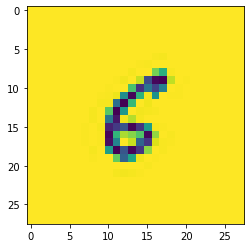

In [ ]:
# check out a sample from client 'f3388_36'
x, y = local_datasets['f3388_36'][0]
print('from client',local_datasets['f3388_36'].user_id)
print('label =', y)
print('features =')
plt.imshow(x.squeeze(0))  # (C,H,W)->(H,W)
plt.show()